# Credit Card Default Prediction System

## Table of contents
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)

<!-- BEGIN QUESTION -->

## Imports

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import mglearn
from IPython.display import display

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
import seaborn as sns

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
DATA_DIR = "../data/"

import warnings
warnings.filterwarnings('ignore')

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<!-- END QUESTION -->

## Introduction <a name="in"></a>

This project works on the classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). 

In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data.

<br><br>

In [4]:
ccdata = pd.read_csv("UCI_Credit_Card.csv")
ccdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
ccdata.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


An immediate problem that I notice with this dataset is that the number of reviews is partially dependent on how long on average a tenant spends in the Airbnb. The Airbnb with id 5022 requires a minimum stay of 10 nights, which means they could at most host 3 tenants over the span of a month and can accordingly get only 3 reviews in a month if each tenent reviews. 

Moreover, the reviews_per_month had missing values. Since this is our target vairable, we had to remove rows where this value was missing

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

In [6]:
X = ccdata.drop(columns = ["default.payment.next.month"])
Y = ccdata[["default.payment.next.month"]]
train_df, test_df = train_test_split(ccdata, test_size=0.3, random_state=123)
train_df = train_df.sort_index().reset_index(drop=True)
test_df = test_df.sort_index().reset_index(drop=True)
X_train = train_df.drop(columns = ["default.payment.next.month"])
Y_train = train_df[["default.payment.next.month"]]
X_test = test_df.drop(columns = ["default.payment.next.month"])
Y_test = test_df[["default.payment.next.month"]]
X_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,2,120000.0,2,2,2,26,-1,2,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,3,90000.0,2,2,2,34,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,4,50000.0,2,2,1,37,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,29996,220000.0,1,3,1,39,0,0,0,0,...,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0
20996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0
20997,29998,30000.0,1,2,2,37,4,3,2,-1,...,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
20998,29999,80000.0,1,3,1,41,1,-1,0,0,...,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>

<Axes: >

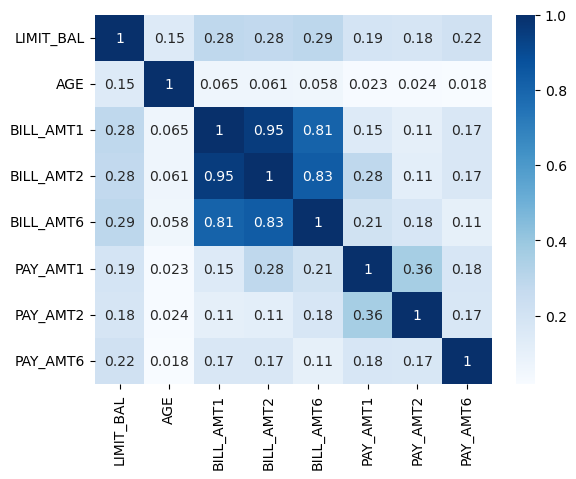

In [7]:
corr_matrix = train_df[["LIMIT_BAL", "AGE",  "BILL_AMT1", "BILL_AMT2", "BILL_AMT6",
                        "PAY_AMT1", "PAY_AMT2", "PAY_AMT6"]].corr()

sns.heatmap(corr_matrix, cmap = "Blues", annot=True, annot_kws={"size": 10})

The bill amounts are largely correlated. This makes sense as a person is likely to have similar bills over different months of in the same year but I am susprised to see that bill and payment amounts or even payment amounts aren't largely correlated with each other. Since the payment amounts are dependent on the bill amounts and bill amounts are correlated, I expected payment amounts to be correlated too.

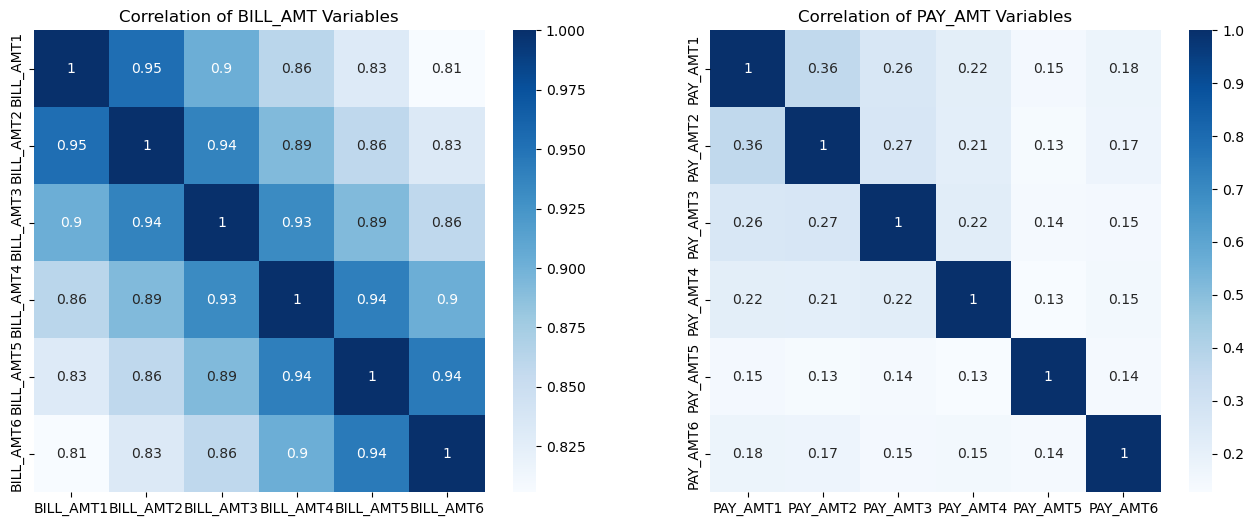

In [8]:
corr_matrix_bill = train_df[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]].corr()
corr_matrix_pay = train_df[["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]].corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(corr_matrix_bill, cmap="Blues", annot=True, annot_kws={"size": 10}, ax=axes[0])
axes[0].set_title("Correlation of BILL_AMT Variables")

sns.heatmap(corr_matrix_pay, cmap="Blues", annot=True, annot_kws={"size": 10}, ax=axes[1])
axes[1].set_title("Correlation of PAY_AMT Variables")

plt.show()

In [9]:
default_counts = train_df['default.payment.next.month'].value_counts(normalize=True)
default_counts

default.payment.next.month
0    0.776762
1    0.223238
Name: proportion, dtype: float64

While there is imbalance in classes, they aren't heavily imbalanced and should not cause issues during predictions

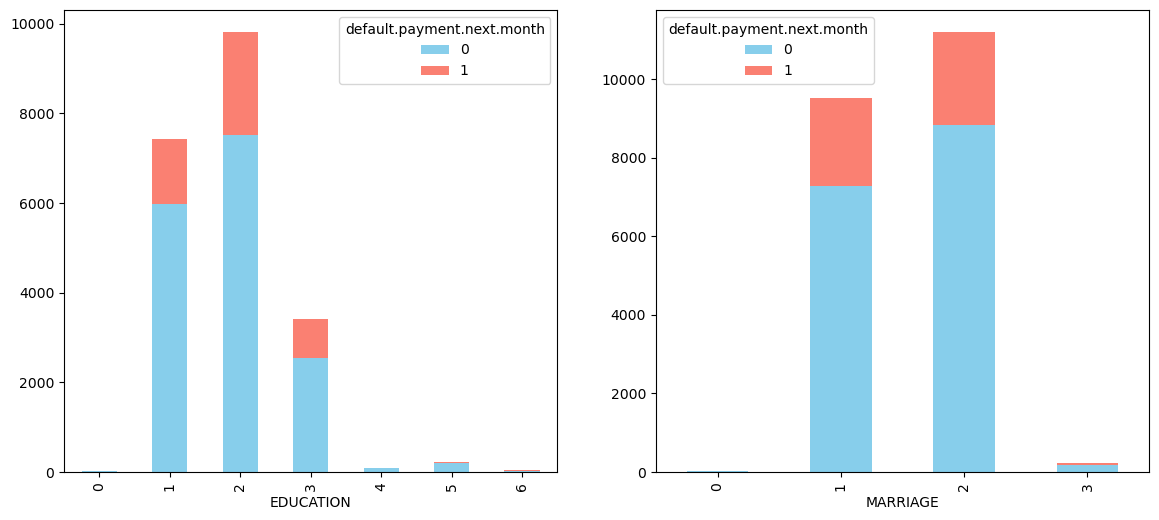

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

train_df.groupby(['EDUCATION', 'default.payment.next.month']).size().unstack().plot(
    kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'salmon']
)

train_df.groupby(['MARRIAGE', 'default.payment.next.month']).size().unstack().plot(
    kind='bar', stacked=True, ax=axes[1], color=['skyblue', 'salmon']
)

plt.show()

Education values of 0, 4, 5, 6 are very rare and so are marriage values for 0 and 1. 

In [11]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>


In [12]:
X["PAY_0"].unique()

array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6])

In [13]:
numeric_feats = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", 
                      "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", 
                      "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
drop_feats = ["ID"]
categorical_feats = ["SEX", "EDUCATION", "MARRIAGE"]
ordinal_feats = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

ordinality = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Even though -2, -1 and 0 do not represent ordinality in the sense that the rest of the values in the column do, one scenario is still considered better than the other. Having no credit card bill to pay is better than paying fully which is better than paying partially which is better than delaying payment by one month, then two months and so on. Accordingly, an ordinal treatment can still function in this case

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>


In [14]:
X_train

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,2,120000.0,2,2,2,26,-1,2,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,3,90000.0,2,2,2,34,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,4,50000.0,2,2,1,37,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,29996,220000.0,1,3,1,39,0,0,0,0,...,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0
20996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0
20997,29998,30000.0,1,2,2,37,4,3,2,-1,...,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
20998,29999,80000.0,1,3,1,41,1,-1,0,0,...,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_feats),  
    (OneHotEncoder(handle_unknown="ignore"), categorical_feats),
    (OrdinalEncoder(categories = [ordinality]* len(ordinal_feats), dtype = int), ordinal_feats), 
    ("drop", drop_feats),
)

In [16]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['SEX', 'EDUCATION', 'MARRIAGE']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[[-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8,
                                                             9]],
                                                dtype=<class 'int'>),
                                 ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6']),
                                ('drop', 'drop', ['ID'])])

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>


In [17]:
from sklearn.dummy import DummyClassifier

results_dict = {}
dummypl = make_pipeline(preprocessor, DummyClassifier())
results_dict["dummy"] = mean_std_cross_val_scores(
    dummypl, X_train, Y_train, cv = 5, return_train_score=True)
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.001),0.003 (+/- 0.000),0.777 (+/- 0.000),0.777 (+/- 0.000)


In [18]:
...

Ellipsis

In [19]:
...

Ellipsis

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>

_The model doesn't improve much with the tuning of the hyperparameter C. The std deviation remains low and doesn't vary much with the fit not improving much either_

In [20]:
from sklearn.linear_model import LogisticRegression

lrpl = make_pipeline(preprocessor, LogisticRegression())
results_dict["logistic regression"] = mean_std_cross_val_scores(
    lrpl, X_train, Y_train, cv = 5, return_train_score=True)
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.001),0.003 (+/- 0.000),0.777 (+/- 0.000),0.777 (+/- 0.000)
logistic regression,0.046 (+/- 0.003),0.003 (+/- 0.000),0.810 (+/- 0.004),0.811 (+/- 0.002)


In [21]:
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
    "std_cv_scores": list()
}

for C in scores_dict["C"]:
    lr = make_pipeline(preprocessor, LogisticRegression(C=C))
    scores = cross_validate(lr, X_train, Y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())
    scores_dict["std_cv_scores"].append(scores["test_score"].std())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores,std_cv_scores
0,0.0001,0.780262,0.780238,0.000452
1,0.0010,0.801857,0.800524,0.001784
2,0.0100,0.809655,0.808000,0.003267
3,0.1000,0.811179,0.809381,0.003672
4,1.0000,0.811143,0.809952,0.003301
5,10.0000,0.811286,0.809905,0.003379
6,100.0000,0.811262,0.809810,0.003587
7,1000.0000,0.811357,0.809905,0.003524
8,10000.0000,0.811238,0.809810,0.003395
9,100000.0000,0.811452,0.810000,0.003447


In [22]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>

_The decision tree model showed overfitting and performed worse than the baseline model (as it often does). Both random forest and LightGBM performed better than decision trees but only marginally better than the linear model (logistic regression)_

In [23]:
from sklearn.tree import DecisionTreeClassifier

pipedt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
results_dict["Decision Tree Classifier"] = mean_std_cross_val_scores(
    pipedt, X_train, Y_train, cv = 5, return_train_score=True)
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.001),0.003 (+/- 0.000),0.777 (+/- 0.000),0.777 (+/- 0.000)
logistic regression,0.046 (+/- 0.003),0.003 (+/- 0.000),0.810 (+/- 0.004),0.811 (+/- 0.002)
Decision Tree Classifier,0.250 (+/- 0.004),0.004 (+/- 0.000),0.720 (+/- 0.008),0.999 (+/- 0.000)


In [24]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1, random_state=123,))

results_dict["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, Y_train, cv = 5, return_train_score=True)

pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.001),0.003 (+/- 0.000),0.777 (+/- 0.000),0.777 (+/- 0.000)
logistic regression,0.046 (+/- 0.003),0.003 (+/- 0.000),0.810 (+/- 0.004),0.811 (+/- 0.002)
Decision Tree Classifier,0.250 (+/- 0.004),0.004 (+/- 0.000),0.720 (+/- 0.008),0.999 (+/- 0.000)
Random forests,0.399 (+/- 0.028),0.018 (+/- 0.001),0.813 (+/- 0.010),0.999 (+/- 0.000)


In [25]:
from lightgbm.sklearn import LGBMClassifier

pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123, verbose=-1))

results_dict["LightGBM"] = mean_std_cross_val_scores(
    pipe_rf, X_train, Y_train, cv = 5, return_train_score=True)

pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.001),0.003 (+/- 0.000),0.777 (+/- 0.000),0.777 (+/- 0.000)
logistic regression,0.046 (+/- 0.003),0.003 (+/- 0.000),0.810 (+/- 0.004),0.811 (+/- 0.002)
Decision Tree Classifier,0.250 (+/- 0.004),0.004 (+/- 0.000),0.720 (+/- 0.008),0.999 (+/- 0.000)
Random forests,0.399 (+/- 0.028),0.018 (+/- 0.001),0.813 (+/- 0.010),0.999 (+/- 0.000)
LightGBM,0.404 (+/- 0.005),0.020 (+/- 0.005),0.813 (+/- 0.010),0.999 (+/- 0.000)


<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr> 

_The test scores don't improve substantially with RFECV or Forward Selection in this case. Accordingly, we omitted feature selection from the rest of the pipeline._

In [26]:
from sklearn.feature_selection import RFECV

rfe_pipe = make_pipeline(
    preprocessor,
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    RandomForestClassifier(n_estimators=100, random_state=123),
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, Y_train, return_train_score=True)).mean()

fit_time       7.890472
score_time     0.011178
test_score     0.818190
train_score    0.819048
dtype: float64

In [27]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_forward = make_pipeline(
    preprocessor,
    SequentialFeatureSelector(LogisticRegression(max_iter=1000), direction="forward", n_features_to_select='auto', tol=None),
    RandomForestClassifier(n_estimators=100, random_state=123))
pd.DataFrame(cross_validate(pipe_forward, X_train, Y_train, return_train_score=True)).mean()

fit_time       18.770496
score_time      0.047701
test_score      0.808190
train_score     0.986833
dtype: float64

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>

_Both random forests and LightGBM improved in performance after conducting randomized search for hyperparameter selection. However, the random forest model now took much more time to run but the LightGBM model took the same amount of time while performing marginally better._

In [28]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    "randomforestclassifier__n_estimators": [100, 200, 300, 400, 500],
    "randomforestclassifier__max_depth": [None, 10, 20, 30, 40, 50],
    "randomforestclassifier__bootstrap": [True, False],}

pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1, random_state=123))

random_search_rf = RandomizedSearchCV(pipe_rf, 
    param_distributions=param_grid_rf,
    n_iter=50, 
    n_jobs=-1,
    random_state=123,
    return_train_score=True
)

random_search_rf.fit(X_train, Y_train.values.ravel())

results_dict["Random forests optimized"] = mean_std_cross_val_scores(
    random_search_rf.best_estimator_, X_train, Y_train.values.ravel(), cv=5, return_train_score=True
)

print(f"Best Parameters: {random_search_rf.best_params_}")
pd.DataFrame(results_dict).T

Best Parameters: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__bootstrap': True}


,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.001),0.003 (+/- 0.000),0.777 (+/- 0.000),0.777 (+/- 0.000)
logistic regression,0.046 (+/- 0.003),0.003 (+/- 0.000),0.810 (+/- 0.004),0.811 (+/- 0.002)
Decision Tree Classifier,0.250 (+/- 0.004),0.004 (+/- 0.000),0.720 (+/- 0.008),0.999 (+/- 0.000)
Random forests,0.399 (+/- 0.028),0.018 (+/- 0.001),0.813 (+/- 0.010),0.999 (+/- 0.000)
LightGBM,0.404 (+/- 0.005),0.020 (+/- 0.005),0.813 (+/- 0.010),0.999 (+/- 0.000)
Random forests optimized,0.671 (+/- 0.019),0.030 (+/- 0.001),0.819 (+/- 0.010),0.865 (+/- 0.002)


In [29]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": [100, 200, 300, 400, 500],
    "lgbmclassifier__max_depth": [None, 10, 20, 30],
    "lgbmclassifier__num_leaves": [30, 50, 100]
}

pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123, verbose = -1))

random_search_lgbm = RandomizedSearchCV(pipe_lgbm, 
    param_distributions=param_grid_lgbm,
    n_iter=50, 
    n_jobs=-1,
    random_state=123,
    return_train_score=True
)

random_search_lgbm.fit(X_train, Y_train.values.ravel())

result_df = pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__max_depth",
        "param_lgbmclassifier__num_leaves",
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

In [30]:
result_df.head()

,param_lgbmclassifier__n_estimators,param_lgbmclassifier__max_depth,param_lgbmclassifier__num_leaves,mean_test_score,mean_fit_time
rank_test_score,,,,,
1,100,10,30,0.819714,3.157754
2,100,20,30,0.819524,2.720229
2,100,None,30,0.819524,2.638676
4,200,10,30,0.817762,6.332887
5,100,None,50,0.817476,4.218163


In [31]:
lgbm_best_model = make_pipeline(preprocessor, LGBMClassifier(
    random_state=123, verbose = -1, n_estimators = 100, max_depth = 20, num_leaves = 30))

results_dict["LightGBM optimized"] = mean_std_cross_val_scores(
    lgbm_best_model, X_train, Y_train.values.ravel(), cv=5, return_train_score=True
)

pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.001),0.003 (+/- 0.000),0.777 (+/- 0.000),0.777 (+/- 0.000)
logistic regression,0.046 (+/- 0.003),0.003 (+/- 0.000),0.810 (+/- 0.004),0.811 (+/- 0.002)
Decision Tree Classifier,0.250 (+/- 0.004),0.004 (+/- 0.000),0.720 (+/- 0.008),0.999 (+/- 0.000)
Random forests,0.399 (+/- 0.028),0.018 (+/- 0.001),0.813 (+/- 0.010),0.999 (+/- 0.000)
LightGBM,0.404 (+/- 0.005),0.020 (+/- 0.005),0.813 (+/- 0.010),0.999 (+/- 0.000)
Random forests optimized,0.671 (+/- 0.019),0.030 (+/- 0.001),0.819 (+/- 0.010),0.865 (+/- 0.002)
LightGBM optimized,0.315 (+/- 0.039),0.006 (+/- 0.000),0.820 (+/- 0.011),0.853 (+/- 0.002)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="1"></a>
<hr>

_SHAP analysis indicated that limit balance, payment amount and education were among the most influential features in predicting credit card default. I was surprised that age wasn't one of the characteristics that was very influential as age would be expected to affect credit card default heavily._

In [35]:
preprocessor.fit(X_train)

ohe_columns = list(
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(categorical_feats)
)

new_columns = numeric_feats + ordinal_feats + ohe_columns

X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)

X_train_enc

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,-1.135800,-1.248402,-0.642607,-0.644620,-0.670993,-0.670657,-0.660751,-0.650606,-0.333097,-0.238799,...,0.0,1.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0
1,-0.367748,-1.031304,-0.659368,-0.663907,-0.642123,-0.620196,-0.604283,-0.595879,-0.333097,-0.224533,...,0.0,0.0,1.0,0.0,1.0,4.0,2.0,2.0,2.0,4.0
2,-0.598164,-0.162911,-0.297765,-0.491606,-0.484564,-0.449642,-0.416445,-0.389657,-0.243975,-0.201598,...,0.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
3,-0.905384,0.162736,-0.056065,-0.012519,0.033036,-0.233994,-0.187454,-0.154737,-0.215677,-0.177792,...,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
4,-0.905384,2.333717,-0.578556,-0.608653,-0.161882,-0.347717,-0.347835,-0.329542,-0.215677,1.412142,...,0.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0.400304,0.379834,1.876851,2.012486,2.337317,0.686554,-0.150223,-0.382424,0.165939,0.646990,...,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
20996,-0.137333,0.814030,-0.672971,-0.662464,-0.630245,-0.532182,-0.575927,-0.650606,-0.225246,-0.108666,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0
20997,-1.058995,0.162736,-0.647345,-0.641063,-0.641022,-0.348674,-0.324365,-0.325750,-0.333097,-0.270403,...,0.0,0.0,1.0,0.0,6.0,5.0,4.0,1.0,2.0,2.0
20998,-0.674969,0.596932,-0.718285,0.409704,0.424335,0.143232,-0.466996,0.170791,4.710103,-0.114033,...,0.0,1.0,0.0,0.0,3.0,1.0,2.0,2.0,2.0,1.0


In [36]:
import shap 

lgbm_shap_model = lgbm_best_model.named_steps['lgbmclassifier']
lgbm_shap_model.fit(X_train_enc, Y_train)

explainer = shap.Explainer(lgbm_shap_model, X_train_enc)

explainer = shap.TreeExplainer(lgbm_shap_model) 
train_shap_values = explainer(X_train_enc) 

shap.initjs()

In [37]:
ex1_idx = 3388
ex2_idx = 20541

print(f"prediction: {lgbm_shap_model.predict(X_train_enc)[ex1_idx]}; true value: {Y_train.iloc[ex1_idx,0]}")
print(f"prediction: {lgbm_shap_model.predict(X_train_enc)[ex2_idx]}; true value: {Y_train.iloc[ex2_idx,0]}")

prediction: 0; true value: 1
prediction: 0; true value: 0


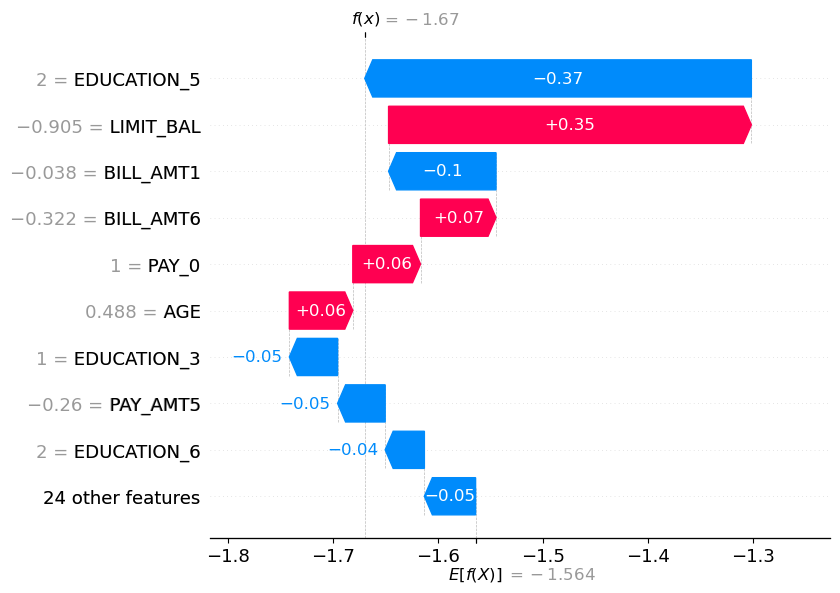

In [38]:
shap.plots.waterfall(train_shap_values[ex1_idx])

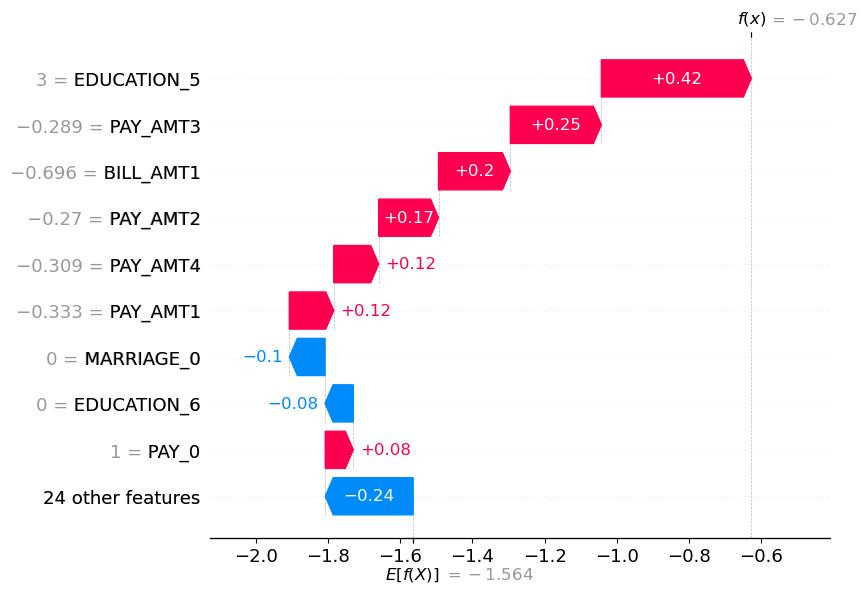

In [39]:
shap.plots.waterfall(train_shap_values[ex2_idx])

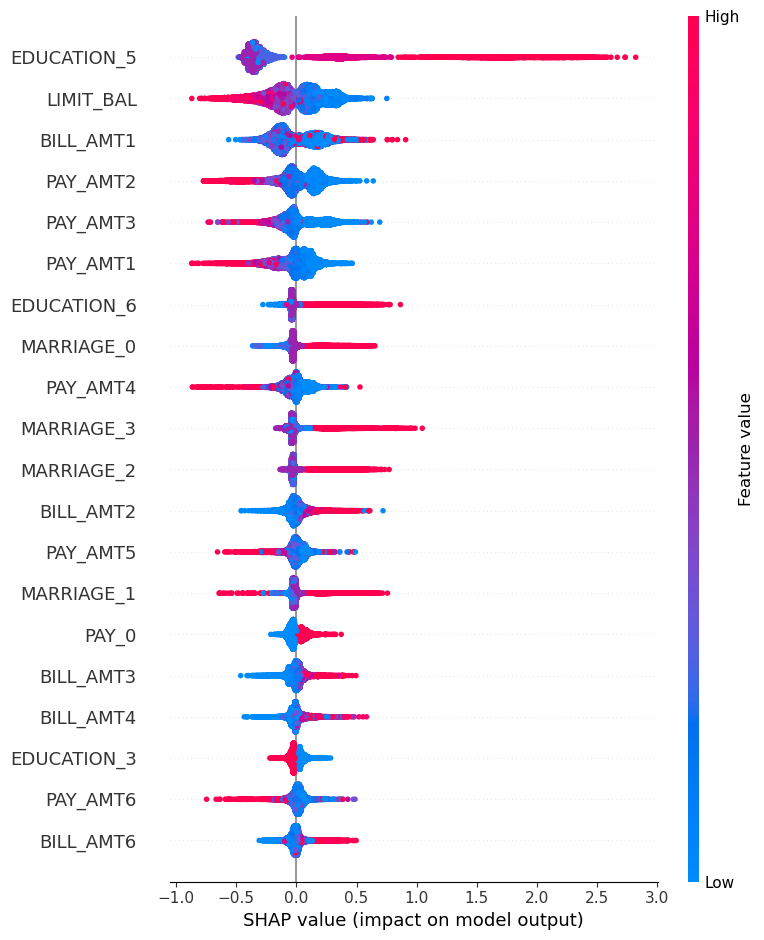

In [40]:
shap.summary_plot(train_shap_values, X_train_enc)

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

_The best model which is a LightGBM model with n_estimators = 100, max_depth = 20, num_leaves = 30, provided a test score of 82.1%, similar to the cross validation score of 81.9%. I think this model can still be improved through more feature engineering and parameter tweaking. I don't think I have had issues with optimization bias as the test set was completely separate from the training set and so were the sets used for cross_validation._

In [45]:
lgbm_best_model = make_pipeline(preprocessor, LGBMClassifier(
    random_state=123, verbose = -1, n_estimators = 100, max_depth = 20, num_leaves = 30))

lgbm_best_model.fit(X_train, Y_train.values.ravel())
lgbm_best_model.score(X_test, Y_test.values.ravel())

0.8211111111111111

In [46]:
preprocessor.fit(X_test)

ohe_columns = list(
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(categorical_feats)
)

new_columns = numeric_feats + ordinal_feats + ohe_columns

X_test_enc = pd.DataFrame(
    preprocessor.transform(X_test), index=X_test.index, columns=new_columns
)

X_test_enc

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,-0.206408,-0.807121,-0.542767,-0.498352,-0.498198,-0.483662,-0.471724,-0.595153,-0.149972,-0.232757,...,0.0,1.0,0.0,0.0,2.0,2.0,4.0,2.0,2.0,2.0
1,0.104453,-0.698779,-0.695101,-0.697890,-0.670982,-0.677111,-0.668680,-0.657684,-0.365985,-0.232757,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2,-0.284123,0.384637,-0.177313,-0.305947,-0.321517,-0.350509,-0.471574,-0.642047,-0.171320,-0.172954,...,0.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0
3,2.202762,0.492978,-0.620695,-0.422987,-0.649962,-0.668239,-0.668680,-0.657684,0.894664,-0.175445,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.594984,-1.348828,-0.631062,-0.597810,-0.670982,-0.591595,-0.562462,-0.518264,0.007577,-0.232757,...,0.0,0.0,1.0,0.0,2.0,2.0,2.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.415313,0.601320,-0.086641,-0.572754,-0.651446,-0.583262,-0.639303,-0.627016,0.207627,0.025713,...,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0
8996,0.104453,-0.373754,-0.695101,-0.697890,-0.670982,-0.677111,-0.668680,-0.657684,-0.365985,-0.232757,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8997,-0.206408,0.601320,1.172124,1.243452,1.314157,1.513257,0.160946,0.117785,0.023344,0.039603,...,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
8998,0.337598,-0.157071,-0.661354,-0.662501,-0.635307,-0.637505,-0.626928,-0.615649,-0.365985,-0.232757,...,0.0,1.0,0.0,0.0,5.0,4.0,4.0,4.0,4.0,4.0


In [47]:
ex1_idx = 2828
ex2_idx = 8539
print(f"prediction: {lgbm_shap_model.predict(X_test_enc)[ex1_idx]}; true value: {Y_test.iloc[ex1_idx,0]}")
print(f"prediction: {lgbm_shap_model.predict(X_test_enc)[ex2_idx]}; true value: {Y_test.iloc[ex2_idx,0]}")

prediction: 1; true value: 1
prediction: 0; true value: 0


In [48]:
shap.force_plot(explainer.expected_value, train_shap_values.values[ex1_idx, :], X_test_enc.iloc[ex1_idx, :])

In [49]:
shap.force_plot(explainer.expected_value, train_shap_values.values[ex2_idx, :], X_test_enc.iloc[ex2_idx, :])

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>

_The LightGBM model performed the best and the cv scores were very similar to the test scores. Both ensemble models performed really well and so did the linear model with the decision tree model performing the worst._

_I could potentially try tweaking more hyperparameters and further feature selection to improve the model. Based on our experience in research, multicollinearity can seriously hinder models and in this case, the billamounts were largely correlated. Keeping just 1 of the bill, payment and pay columns might be useful and prevent them from having such a large impact on the model._

In [56]:
test_score = lgbm_best_model.score(X_test, Y_test.values.ravel())
results_dict["LightGBM optimized (Test)"] = {
    "fit_time": "-",  
    "score_time": "-",  
    "test_score": f"{test_score:.3f}",
    "train_score": "-"  
}
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.001),0.003 (+/- 0.000),0.777 (+/- 0.000),0.777 (+/- 0.000)
logistic regression,0.046 (+/- 0.003),0.003 (+/- 0.000),0.810 (+/- 0.004),0.811 (+/- 0.002)
Decision Tree Classifier,0.250 (+/- 0.004),0.004 (+/- 0.000),0.720 (+/- 0.008),0.999 (+/- 0.000)
Random forests,0.399 (+/- 0.028),0.018 (+/- 0.001),0.813 (+/- 0.010),0.999 (+/- 0.000)
LightGBM,0.404 (+/- 0.005),0.020 (+/- 0.005),0.813 (+/- 0.010),0.999 (+/- 0.000)
Random forests optimized,0.671 (+/- 0.019),0.030 (+/- 0.001),0.819 (+/- 0.010),0.865 (+/- 0.002)
LightGBM optimized,0.315 (+/- 0.039),0.006 (+/- 0.000),0.820 (+/- 0.011),0.853 (+/- 0.002)
LightGBM optimized (Test),-,-,0.820,-


<!-- BEGIN QUESTION -->

## 14. Takeaway <a name="15"></a>
<hr>

My biggest takeaway from this project was understanding the practical advantages of RandomizedSearchCV over GridSearchCV. Initially, I tried using GridSearchCV, but it took quite long to run and my device almost crashed. I switched to RandomizedSearchCV which actually ran and allowed for hyperparameter tuning. 

I also realized the potential impact of feature engineering. I will keep working on this, and believe more thorough feature engineering will eventually significantly boost model performance. I refuse to believe that strategic feature engineering could not have further improved results.